# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

In [2]:
import sys
sys.path.append("../notebooks/scripts/")

# Imports Section 

In [3]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import seaborn as sns

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [4]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [5]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [6]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver
    import selenium.webdriver
    
    driver = selenium.webdriver.Chrome()
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Zika Specific Variables 

In [7]:
try:
    colors = snakemake.input.colors
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df
    tsne_df = snakemake.input.tsne_df
    umap_df = snakemake.input.umap_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [8]:
clades_to_plot = None

In [9]:
domain = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c9', 'c10', "unassigned"]
range_ = ['#4f61ff', '#71cfd4', '#97e59f', '#c7f071', '#f8e957', '#ffcc49', '#ff903e', '#ff3b2d', '#58a3fd', '#4f92e4', '#000000']

# Reading in all the data from the scripts

In [10]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/zika-nextstrain'

In [11]:
#node_df = pd.read_csv(node_df, sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)
node_df = node_df.take(node_df["clade_membership"].dropna().index.values.tolist())

In [12]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [13]:
node_df['clade_membership'].value_counts()

c4            140
c2            123
c3            110
c5            105
c7             44
c6             43
c1             43
c9             34
c10            29
unassigned      3
Name: clade_membership, dtype: int64

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [14]:
#principalDf = pd.read_csv(pca_df, index_col=0)
principalDf = pd.read_csv("results/embed_pca_sequences.csv", index_col=0)

In [15]:
#explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df = pd.read_csv("results/explained_variance_pca_sequences.csv")
explained_variance_df

explained variance  principal components
0              0.3304                     1
1              0.0668                     2
2              0.0582                     3
3              0.0411                     4
4              0.0277                     5
5              0.0181                     6
6              0.0137                     7
7              0.0127                     8
8              0.0100                     9
9              0.0085                    10

NameError: name 'snakemake' is not defined

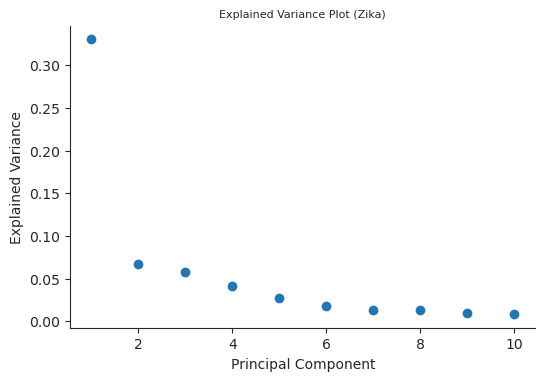

In [16]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (Zika)")

plt.savefig(snakemake.output.Explained_variance_PCA)

In [22]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [23]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4  \
0  FrenchPolynesia2014_060114_016 -0.998547 -0.175069 -0.003561  0.361745   
1                       1_0049_PF -1.198790 -0.180801  0.006346  0.362463   
2                       1_0030_PF -0.799810 -0.187487 -0.026014  0.402228   
3                       1_0035_PF -0.796745 -0.175749 -0.004483  0.412166   
4                       1_0087_PF -0.796488 -0.175817 -0.005464  0.405828   

       pca5      pca6      pca7      pca8      pca9     pca10  pca_label  \
0  1.458287  0.384682  0.105213 -0.495075 -0.058393  0.096919         -1   
1  1.145100  0.554967  0.122504 -0.539326 -0.060135  0.060048          7   
2  1.683231  0.217245  0.093380 -0.469679 -0.057281  0.115447         -1   
3  1.666182  0.218447 -0.005780 -0.474135 -0.050990  0.123062         -1   
4  1.662626  0.223019  0.092407 -0.445756 -0.051656  0.118796         -1   

   pca_label_default     date    y clade_membership clade_membership_color  
0                 -1  2014.02  155               c1                     c1  
1                  7  2014.00  159               c1                     c1  
2                 -1  2013.84  128               c1                     c1  
3                 -1  2014.09  130               c1                     c1  
4                 -1  2013.92  131               c1                     c1

In [24]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [25]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [26]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

In [27]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

NameError: name 'scatterplot_pca' is not defined

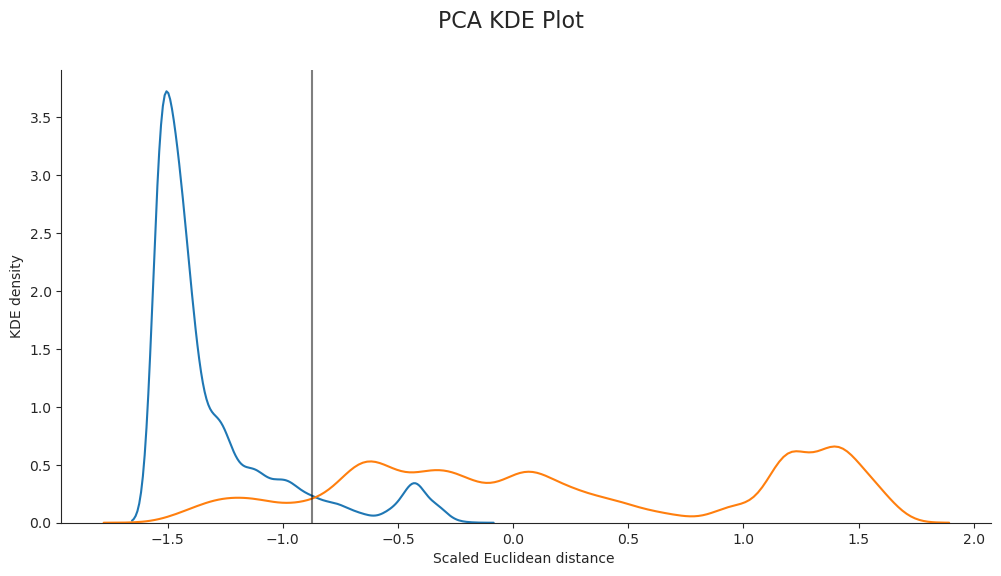

In [28]:
KDE_pca = "results/KDEDensity_pca.csv"
KDE_pca_metadata = "results/KDEDensity_pca_metadata.csv"

PCA_KDE_df = pd.read_csv(KDE_pca)
PCA_KDE_metadata_df = pd.read_csv(KDE_pca_metadata)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance ")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [31]:
MDS_df = pd.read_csv("results/embed_mds_sequences.csv",index_col=0)
#MDS_df = pd.read_csv(mds_df,index_col=0)

In [32]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [33]:
merged_mds_df

strain       mds1       mds2      mds3  \
0    FrenchPolynesia2014_060114_016   3.809836  -3.069898 -6.529109   
1                         1_0049_PF   0.389267   0.110348 -1.559379   
2                         1_0030_PF   2.707430  -2.393333 -5.255226   
3                         1_0035_PF   3.511799  -2.493671 -6.907421   
4                         1_0087_PF   2.014812  -1.730671 -3.279304   
..                              ...        ...        ...       ...   
669                  MEX/2016/mex45  -1.704699   5.634088 -5.042461   
670                         Bahia15  -3.911900   1.656532  1.519804   
671              NIC/5847_12B1/2016   1.273649   1.446956  1.464251   
672                USA/2016/FLUR005 -16.313066  16.618560 -4.364965   
673                USA/2016/FLUR001  -9.269670  15.302092 -4.956744   

          mds4      mds5       mds6       mds7      mds8       mds9     mds10  \
0    -3.145373 -3.128420   3.460233  -6.030342 -2.247870  -2.095229  3.118908   
1    -2.159271  0.803943   1.802560  -1.982709 -1.433679  -1.498819  1.068426   
2    -2.853650 -3.472684   1.520105  -4.130519 -4.082948   0.638078  0.042992   
3    -3.774619 -3.341821   1.511347  -5.062114 -4.760888  -0.123058 -0.967759   
4    -1.812227 -2.044347   0.143154  -2.957065 -2.851998   0.717363 -0.212681   
..         ...       ...        ...        ...       ...        ...       ...   
669 -10.585817  5.612018   9.626869  15.280847 -7.148905  -6.935330 -3.300084   
670  -2.236998  5.246146   4.378863  -2.513459 -1.473262  -2.546469  2.295847   
671  10.091534  3.416055  16.552594  -0.038720  1.962459  -8.012640  2.784368   
672  -5.343007  5.707659  -5.842957   4.359890  2.714368 -10.158482  1.821485   
673  -5.382228  4.335615  -5.359292   2.627319  8.873318  -9.958727  6.410479   

     mds_label  mds_label_default     date    y clade_membership  \
0            1                  1  2014.02  155               c1   
1            1                  1  2014.00  159               c1   
2            1                  1  2013.84  128               c1   
3            1                  1  2014.09  130               c1   
4            1                  1  2013.92  131               c1   
..         ...                ...      ...  ...              ...   
669          1                  1  2016.50  549               c4   
670          1                  1  2016.00  187               c3   
671          1                  1  2016.11  591               c4   
672          1                  1  2016.58  447               c5   
673          1                  1  2016.58  435               c5   

    clade_membership_color  
0                       c1  
1                       c1  
2                       c1  
3                       c1  
4                       c1  
..                     ...  
669                     c4  
670                     c3  
671                     c4  
672                     c5  
673                     c5  

[674 rows x 17 columns]

In [34]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_12_mds

alt.Chart(...)

In [35]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [36]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

In [38]:
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

NameError: name 'scatterplot_mds' is not defined

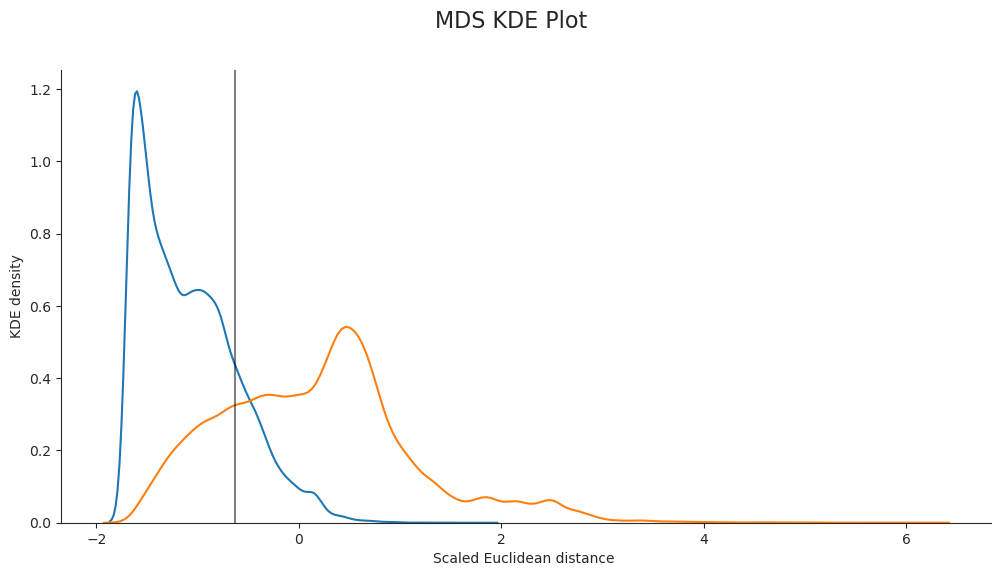

In [39]:
KDE_mds = "results/KDEDensity_mds.csv"
KDE_mds_metadata = "results/KDEDensity_mds_metadata.csv"

MDS_KDE_df = pd.read_csv(KDE_mds)
MDS_KDE_metadata_df = pd.read_csv(KDE_mds_metadata)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance ")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [40]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color", "tsne_x", "tsne_y"]]

In [41]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["clade_membership:N","strain:N"],
    domain,
    range_
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [42]:
list_of_chart = linking_tree_with_plots_clickable(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ['t-sne_label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

In [43]:
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")

ax.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

NameError: name 'scatterplot_tsne' is not defined

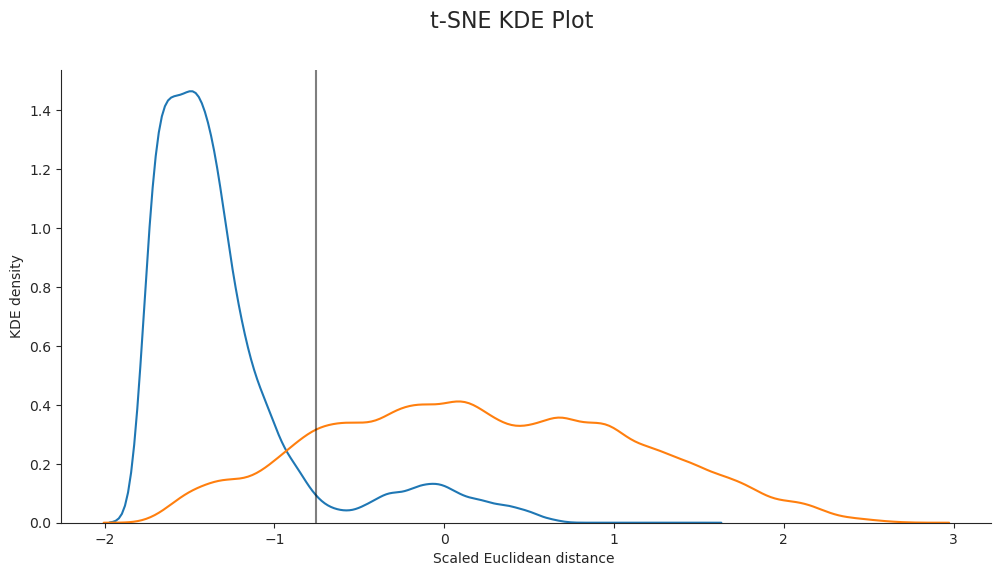

In [44]:
KDE_tsne = "results/KDEDensity_t-sne.csv"
KDE_tsne_metadata = "results/KDEDensity_t-sne_metadata.csv"

TSNE_KDE_df = pd.read_csv(KDE_tsne)
TSNE_KDE_metadata_df = pd.read_csv(KDE_tsne_metadata)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance ")
ax.set_ylabel("KDE density")

fig.suptitle('t-SNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [45]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("results/embed_umap_sequences.csv",index_col=0)

In [46]:
UMAP_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color", "umap_x", "umap_y", "umap_label"]]

In [47]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership:N',
    ["clade_membership:N","strain:N"],
    domain,
    range_
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

# HDBSCAN Output

In [48]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'umap_label:N',
    ['umap_label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

In [49]:
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")

ax.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")
sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

NameError: name 'scatterplot_umap' is not defined

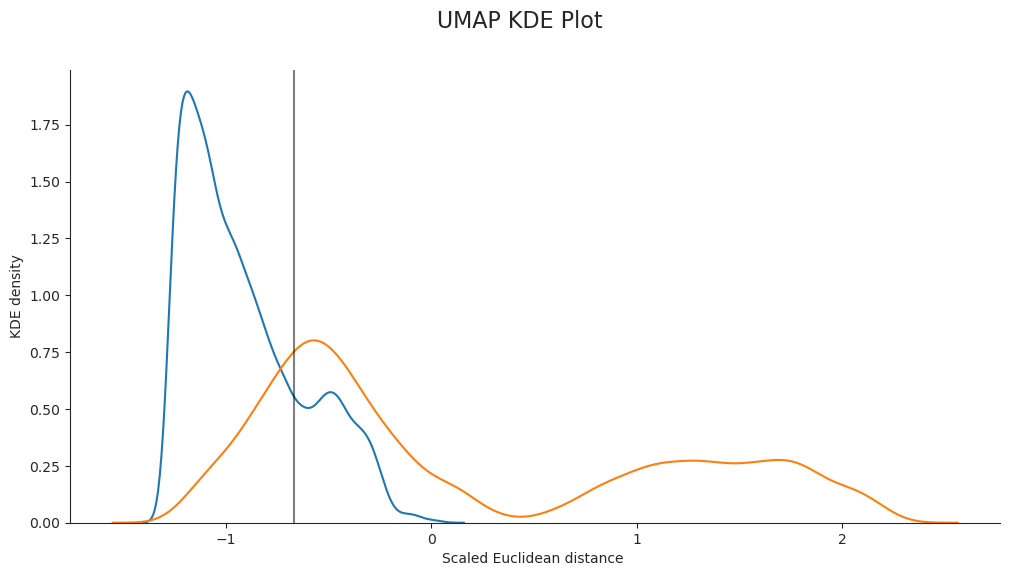

In [50]:
KDE_umap = "results/KDEDensity_umap.csv"
KDE_umap_metadata = "results/KDEDensity_umap_metadata.csv"


UMAP_KDE_df = pd.read_csv(KDE_umap)
UMAP_KDE_metadata_df = pd.read_csv(KDE_umap_metadata)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance ")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [52]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2', 'mds3', 'mds4', 'tsne_x','tsne_y', 'pca1', 'pca2', 'pca3', 'pca4','umap_x','umap_y'],
    ['MDS1', 'MDS2', 'MDS3', 'MDS4', 'TSNE1', 'TSNE2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
    'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")", 'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [39]:
PCA_ = data[4]|data[5]
MDS_ = data[1]|data[2]
PCAMDS = alt.vconcat(PCA_, MDS_)
TSNEUMAP = data[3]|data[6]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
fullChart.save(snakemake.output.fullChart)
fullChart.save(snakemake.output.fullChartPNG, scale_factor=2.0)

alt.VConcatChart(...)

In [52]:
fullChart

alt.HConcatChart(...)

In [58]:
node_df

strain     date  pca1  pca2  pca3  pca4   mds1   mds2  \
0                    SG_021  2016.70  5.31 -0.15 -0.02  0.23  52.99  30.02   
1                  SI_BKK06  2017.69  3.21 -0.01  0.25 -0.13  48.72  23.65   
2                     BKK07  2017.75  7.23 -0.05 -0.15  0.09   4.14   4.01   
3         Thailand/1610acTw  2016.83  7.38  0.04 -0.03  0.06   9.15   7.33   
4        Thai/KngSG/17_D501  2018.00  7.31  0.05 -0.05 -0.02 -12.15  38.64   
..                      ...      ...   ...   ...   ...   ...    ...    ...   
669          MEX/2016/mex36  2016.51 -1.76 -2.01 -2.30 -0.51  -8.94 -12.47   
670          MEX/2016/mex40  2016.50 -1.66 -2.19 -2.34 -0.57  -5.96  -6.71   
671          MEX/2016/mex23  2016.39 -1.76 -2.19 -2.34 -0.56  -8.13  -7.86   
672  MEX/42_001_F_V0_O/2016  2016.48 -1.66 -2.19 -2.33 -0.56  -7.79  -6.33   
673  MEX/42_001_F_V3_O/2016  2016.49 -1.76 -2.19 -2.32 -0.56  -4.90  -4.86   

      mds3   mds4  ...  tsne_y  umap_x  umap_y  clade_membership pca_label  \
0     8.45 -18.24  ...   34.03   15.31  -15.15        unassigned        -1   
1    12.75 -17.60  ...   33.46   15.35  -15.29        unassigned        -1   
2    51.77 -17.81  ...   40.02   15.76  -15.53                c2        -1   
3    34.68 -25.10  ...   41.37   15.48  -14.94                c2        -1   
4    56.54 -22.80  ...   41.63   15.59  -15.70                c2        -1   
..     ...    ...  ...     ...     ...     ...               ...       ...   
669 -25.67  16.56  ...  -14.08    0.41   12.99                c4         3   
670 -17.63  20.13  ...  -15.97   -0.01   13.06                c4         3   
671  -9.18  13.40  ...  -15.53   -2.06   14.19                c4         3   
672 -16.79   6.39  ...  -15.87   -1.81   14.04                c4         3   
673 -11.43  15.51  ...  -15.86   -1.64   14.02                c4         3   

     mds_label  umap_label  t-sne_label    y  clade_membership_color  
0           -1           6            0    1              unassigned  
1           -1           6            0    2              unassigned  
2           -1          -1            0    3                      c2  
3           -1           6            0    4                      c2  
4           -1          -1            0    5                      c2  
..         ...         ...          ...  ...                     ...  
669         -1           0            2  670                      c4  
670         -1           0            2  671                      c4  
671         -1           0            2  672                      c4  
672         -1           0            2  673                      c4  
673         -1           0            2  674                      c4  

[674 rows x 21 columns]

In [ ]:
colors = pd.read_csv("../notebooks/config/color_schemes.tsv", sep="\t", names=[i for i in range(0,101)])

In [12]:
from Helpers import get_euclidean_data_frame
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [13]:
def _get_embedding_columns_by_method(method):
    if method in ("pca"):
        return list(f"{method}1 {method}2 {method}3 {method}4".split())
    if method in ("mds"):
        return list(f"{method}1 {method}2".split())
    if method in ("t-sne"):
        return list("tsne_x tsne_y".split())
    else:
        return list(f"{method}_x {method}_y".split())

In [14]:
MCC_val = []

for method in ["pca", "mds", "t-sne", "umap"]:
    KDE_df_normal = get_euclidean_data_frame(sampled_df=node_df, column_for_analysis="clade_membership", embedding="method", column_list=_get_embedding_columns_by_method(method))

    KDE_df_cluster =  get_euclidean_data_frame(sampled_df=node_df, column_for_analysis=f"{method}_label", embedding="method", column_list=_get_embedding_columns_by_method(method))

    confusion_matrix_val = confusion_matrix(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    matthews_cc_val = matthews_corrcoef(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    MCC_val.append(matthews_cc_val)

In [15]:
domain =  sorted(node_df["pca_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
PCA = linking_tree_with_plots_brush(
    node_df,
    ['pca1', 'pca2'],
    ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][1]*100,2)) + ")"],
    'pca_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["mds_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
MDS = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2'],
    ['MDS1', 'MDS2'],
    'mds_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["t-sne_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
TSNE = linking_tree_with_plots_brush(
    node_df,
    ['tsne_x', 'tsne_y'],
    ['TSNE1', 'TSNE2'],
    't-sne_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["umap_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
UMAP = linking_tree_with_plots_brush(
    node_df,
    ['umap_x', 'umap_y'],
    ['UMAP1', 'UMAP2'],
    'umap_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [16]:
PCAChart = PCA[0]|PCA[1].properties(title= "MCC Value: " + str(round(MCC_val[0],3)))
MDSChart = MDS[0]|MDS[1].properties(title= "MCC Value: " + str(round(MCC_val[1],3)))
TSNEChart = TSNE[0]|TSNE[1].properties(title= "MCC Value: " + str(round(MCC_val[2],3)))
UMAPChart = UMAP[0]|UMAP[1].properties(title= "MCC Value: " + str(round(MCC_val[3],3)))

In [19]:
PCAMDS = alt.vconcat(PCAChart, MDSChart).resolve_scale(color='independent')
TSNEUMAP = alt.vconcat(TSNEChart, UMAPChart).resolve_scale(color='independent')
fullChart = alt.vconcat(PCAMDS, TSNEUMAP).resolve_scale(color='independent')
fullChart
fullChart.save(snakemake.output.fullChartHDBSCAN)
save(fullChart, snakemake.output.fullChartHDBSCANPNG, scale_factor=2.0)

WARN Symbol legend count exceeds limit, filtering items.


## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [ ]:
import matplotlib.gridspec as gridspec

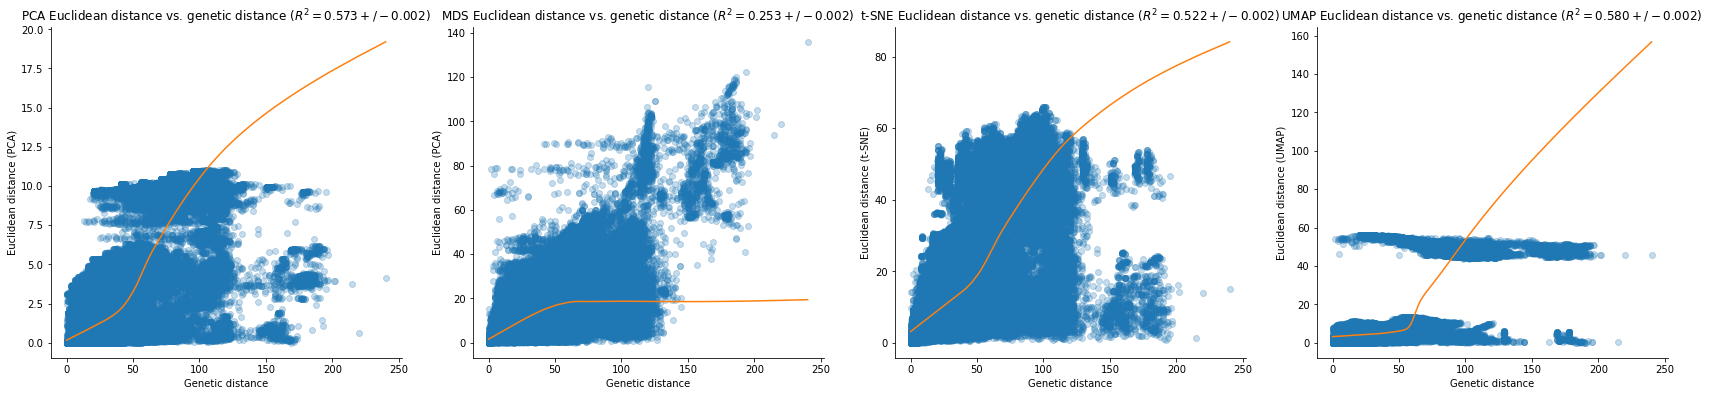

In [74]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.tight_layout(pad=8.0)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.8)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot, dpi=300)

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [75]:
KDE_genetic = "results/KDEDensity_genetic.csv"
KDE_genetic_metadata = "results/KDEDensity_genetic_metadata.csv"

Genetic_KDE_df = pd.read_csv(KDE_genetic)
Genetic_KDE_metadata_df = pd.read_csv(KDE_genetic_metadata)

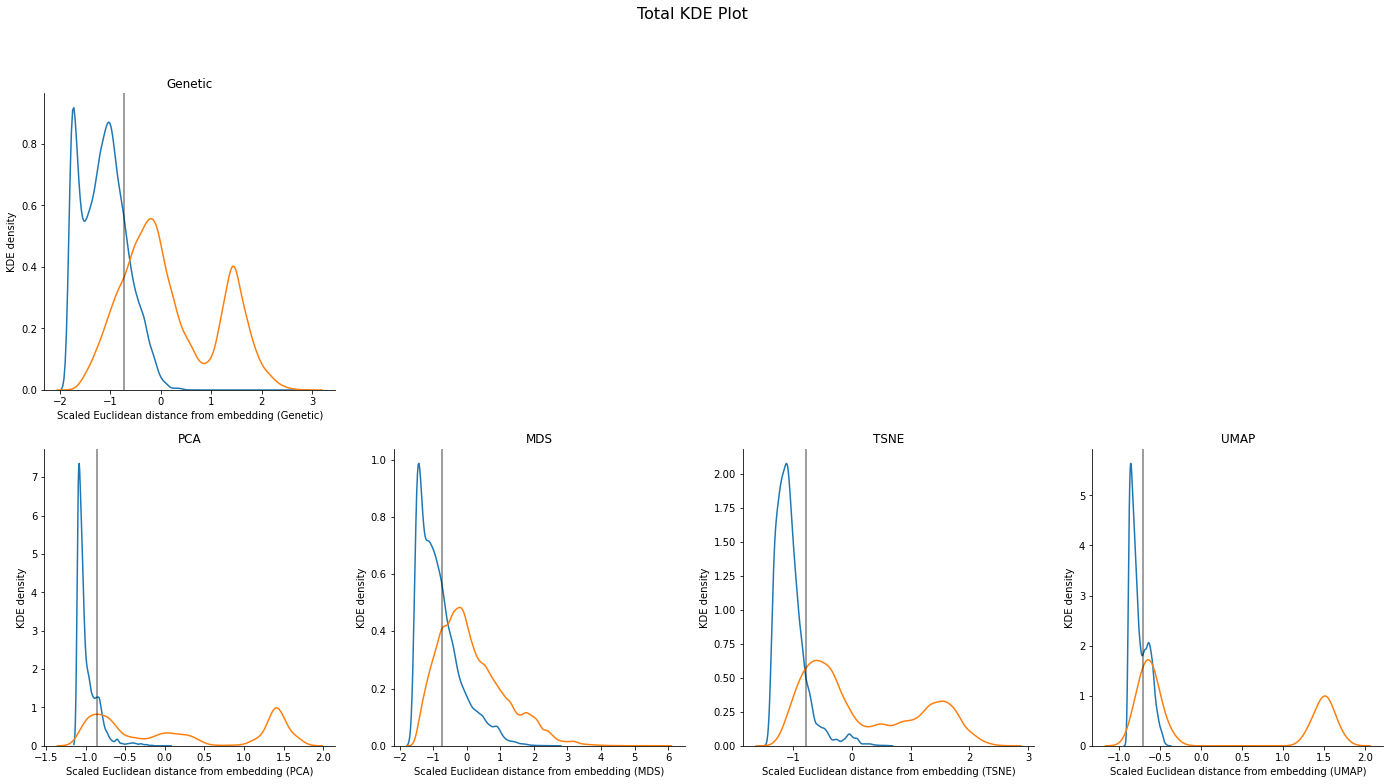

In [77]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic : MCC Value(' + str(round(Genetic_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax1.set_xlabel("Scaled Euclidean distance (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('PCA : MCC Value(' + str(round(PCA_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax2.set_xlabel("Scaled Euclidean distance (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('MDS : MCC Value(' + str(round(MDS_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax3.set_xlabel("Scaled Euclidean distance (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax4.legend(frameon=False)
ax4.set_title('TSNE : MCC Value(' + str(round(TSNE_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax4.set_xlabel("Scaled Euclidean distance (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.legend(frameon=False)
ax5.set_title('UMAP: MCC Value(' + str(round(UMAP_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax5.set_xlabel("Scaled Euclidean distance (UMAP)")
ax5.set_ylabel("KDE density")

sns.despine()
plt.savefig(snakemake.output.KDE_density, dpi=600, bbox_inches='tight')

# Supplemental Figures

In [55]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.MDS_Supplement)
chart.save(snakemake.output.MDS_Supplement_PNG)

alt.HConcatChart(...)

In [56]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]
chart.save(snakemake.output.PCA_Supplement)
chart.save(snakemake.output.PCA_Supplement_PNG)

alt.HConcatChart(...)

# HDBSCAN Final Charts

In [29]:
node_df = pd.read_csv("results/table.tsv", sep="\t")
#node_df = pd.read_csv(node_df, sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [30]:
colors = pd.read_csv("../notebooks/config/color_schemes.tsv", sep="\t", names=[i for i in range(0,101)])
#colors = pd.read_csv(colors, sep="\t", names=[i for i in range(0,101)])

In [31]:
PCA_df = pd.read_csv("results/embed_pca_sequences.csv",index_col=0)
MDS_df = pd.read_csv("results/embed_mds_sequences.csv",index_col=0)
TSNE_df = pd.read_csv("results/embed_t-sne_sequences.csv",index_col=0)
UMAP_df = pd.read_csv("results/embed_umap_sequences.csv",index_col=0)
explained_variance_df = pd.read_csv("results/explained_variance_pca_sequences.csv")


#PCA_df = pd.read_csv(pca_df,index_col=0)
#MDS_df = pd.read_csv(mds_df,index_col=0)
#TSNE_df = pd.read_csv(tsne_df,index_col=0)
#UMAP_df = pd.read_csv(umap_df,index_col=0)
#explained_variance_df = pd.read_csv(explained_variance_pca)

In [32]:
node_df = node_df[["strain", "date", "clade_membership", "y"]].merge(
    PCA_df,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [33]:
from Helpers import get_euclidean_data_frame
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [34]:
def _get_embedding_columns_by_method(method):
    if method in ("pca"):
        return list(f"{method}1 {method}2 {method}3 {method}4 {method}5 {method}6 {method}7 {method}8 {method}9 {method}10".split())
    if method in ("mds"):
        return list(f"{method}1 {method}2".split())
    if method in ("t-sne"):
        return list("tsne_x tsne_y".split())
    else:
        return list(f"{method}_x {method}_y".split())

In [35]:
MCC_val = []

for method in ["pca", "mds", "t-sne", "umap"]:
    KDE_df_normal = get_euclidean_data_frame(sampled_df=node_df, column_for_analysis="clade_membership", embedding="method", column_list=_get_embedding_columns_by_method(method))

    KDE_df_cluster =  get_euclidean_data_frame(sampled_df=node_df, column_for_analysis=f"{method}_label", embedding="method", column_list=_get_embedding_columns_by_method(method))

    confusion_matrix_val = confusion_matrix(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    matthews_cc_val = matthews_corrcoef(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    MCC_val.append(matthews_cc_val)

In [40]:
domain =  sorted(node_df["pca_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
PCA = linking_tree_with_plots_brush(
    node_df,
    ['pca1', 'pca2'],
    ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][1]*100,2)) + ")"],
    'pca_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["mds_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
MDS = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2'],
    ['MDS1', 'MDS2'],
    'mds_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["t-sne_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
TSNE = linking_tree_with_plots_brush(
    node_df,
    ['tsne_x', 'tsne_y'],
    ['TSNE1', 'TSNE2'],
    't-sne_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["umap_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
UMAP = linking_tree_with_plots_brush(
    node_df,
    ['umap_x', 'umap_y'],
    ['UMAP1', 'UMAP2'],
    'umap_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [41]:
PCAChart = PCA[0]|PCA[1].properties(title= "MCC Value: " + str(round(MCC_val[0],3)))
MDSChart = MDS[0]|MDS[1].properties(title= "MCC Value: " + str(round(MCC_val[1],3)))
TSNEChart = TSNE[0]|TSNE[1].properties(title= "MCC Value: " + str(round(MCC_val[2],3)))
UMAPChart = UMAP[0]|UMAP[1].properties(title= "MCC Value: " + str(round(MCC_val[3],3)))

In [42]:
PCAMDS = alt.vconcat(PCAChart, MDSChart).resolve_scale(color='independent')
TSNEUMAP = alt.vconcat(TSNEChart, UMAPChart).resolve_scale(color='independent')
fullChart = alt.vconcat(PCAMDS, TSNEUMAP).resolve_scale(color='independent')
fullChart
#fullChart.save(snakemake.output.fullChartHDBSCAN)
#save(fullChart, snakemake.output.fullChartHDBSCANPNG, scale_factor=2.0)

alt.VConcatChart(...)